In [1]:
Base.:*(a::Array{T,1}, b::Array{T,1}) where {T <: Real} = a .* b

In [2]:
# Tipo para almacenar funciones de transferencia y sus derivadas
TransferFunction = NamedTuple{(:f, :f′), Tuple{Function, Function}}

# Funciones de activacion y sus derivadas
σ = TransferFunction((
        # σ
        (x) -> begin
            if x >= 0
                z = exp(-x)
                return 1 / (1 + z)
            else
                z = exp(x)
                return z / (1 + z)
            end
        end,
        
        # σ′
        (z) -> (1 - z)z
    ))

ReLU = TransferFunction(( 
        (x) -> ifelse(x >= 0, x, 0),
        (z) -> ifelse(z >= 0, 1, 0)
    ))

PureLim = TransferFunction(( 
        (x) -> x,
        (z) -> 1
    ))

hardlim = TransferFunction(( 
        (x) -> ifelse(x >= 0, 1, 0),
        (z) -> 1
    ))

NamedTuple{(:f, :f′),Tuple{Function,Function}}((getfield(Main, Symbol("##15#17"))(), getfield(Main, Symbol("##16#18"))()))

In [3]:
# Funciones de costo
CostFunction = TransferFunction

J = CostFunction((
        (Ŷ, Y) -> (@. (1/2) * (Y - Ŷ) ^ 2),
        (Ŷ, Y) -> -(Y - Ŷ)
    ))

NamedTuple{(:f, :f′),Tuple{Function,Function}}((getfield(Main, Symbol("##19#21"))(), getfield(Main, Symbol("##20#22"))()))

In [4]:
# Capas de la red
mutable struct Layer
    size::Tuple{<:Integer, <:Integer}
    tf::TransferFunction
    W::VecOrMat
    b::Vector
    # Cache output
    z::Vector
    a::Vector
    δ::Vector
    
    Layer(size, tf, W, b, z, a, δ) = new(size, tf, W, b, z, a, δ)
    Layer(size, tf, W, b) where {T} = new(size, tf, W, b)
    function Layer(size::Tuple{<:Integer, <:Integer}, f::TransferFunction)
        new(size, f, randn(T, size[1], size[2]) * 1/√size[1], randn(T, size[1]))
    end
    function Layer(size::Tuple{<:Integer, <:Integer})
        new(size, σ)
    end
    Layer(neurons, inputs, f) = Layer((neurons, inputs), f)
    Layer(neurons, inputs) = Layer((neurons, inputs), σ)
end

In [5]:
mutable struct NeuralNetwork
    layers::Vector{Layer}
    J::CostFunction
    α::AbstractFloat
    error::Vector

    NeuralNetwork(layers, J, rate, error) = new(layers, J, rate, error)
    NeuralNetwork(layers, J, rate) = new(layers, J, rate)
    NeuralNetwork(layers::Vector{Layer}, J, rate) = new(layers, J, rate)
end

In [6]:
function forward(net::Layer, X)
    net.z = net.W * X + net.b
    net.a = @. net.tf.f(net.z)
    return net.a
end

function forward(net::NeuralNetwork, X)
    a = Vector()
    push!(a, X)
    for layer in net.layers
        push!(a, forward(layer, a[end]))
    end
    return a
end

forward (generic function with 2 methods)

In [7]:
# Calcula la sensibilidad de la capa
function backward(layer::Layer, next::Layer)
    # δ es la sensibilidad de la capa posterior
    a  = layer.a
    f′ = layer.tf.f′
    W  = next.W
    δ  = next.δ
    
    layer.δ = W' .* f′.(a) * δ
    return layer.δ
end

# Calcula el error de toda la red
function backward(net::NeuralNetwork, X, Y)
    a         = forward(net, X) # activaciones
    net.error = Vector()
    # Primer capa
    # ∂J/∂W = ∂J/∂a * ∂a/∂z * ∂z/∂W
    Ŷ         = a[end]
    ∂J        = net.J.f′(Ŷ, Y)            # ∂J/∂a = (Y-Ŷ)
    ∂a        = net.layers[end].tf.f′.(Ŷ) # ∂a/∂z = f′(z)
    δ         = ∂a .* ∂J                  # multiplicacion elemento a elemento
    ∂z        = a[end-1]                  # ∂z/∂W = activacion de la capa anterior
    net.layers[end].δ = δ
    ∂J∂W = sum(∂z * δ', dims=2)
    
    pushfirst!(net.error, ∂J∂W)           # error de la red

    for l ∈ reverse(eachindex(net.layers[1:end-1]))
        δ    = backward(net.layers[l], net.layers[l+1])
        ∂J∂W = sum(a[l] * δ', dims=2)

        pushfirst!(net.error, ∂J∂W) # Guardamos el error de la capa
    end

    return ∂J
end

backward (generic function with 2 methods)

In [8]:
# Actualiza los pesos
function update(net::NeuralNetwork)
    for (l, layer) ∈ enumerate(net.layers)
        layer.W = layer.W .- net.α * net.error[l]'
        layer.b -= net.α * layer.δ
    end
end

update (generic function with 1 method)

# Ejercicio 2

In [9]:
using Plots

In [10]:
net = NeuralNetwork([
        Layer((2, 1), σ, [-0.27; -0.41], [-0.48, -0.13]),
        Layer((1, 2), PureLim, [0.09 -0.17], [0.48])], 
    J, 0.1)

NeuralNetwork(Layer[Layer((2, 1), NamedTuple{(:f, :f′),Tuple{Function,Function}}((##3#5(), ##4#6())), [-0.27, -0.41], [-0.48, -0.13], #undef, #undef, #undef), Layer((1, 2), NamedTuple{(:f, :f′),Tuple{Function,Function}}((##11#13(), ##12#14())), [0.09 -0.17], [0.48], #undef, #undef, #undef)], NamedTuple{(:f, :f′),Tuple{Function,Function}}((getfield(Main, Symbol("##19#21"))(), getfield(Main, Symbol("##20#22"))())), 0.1, #undef)

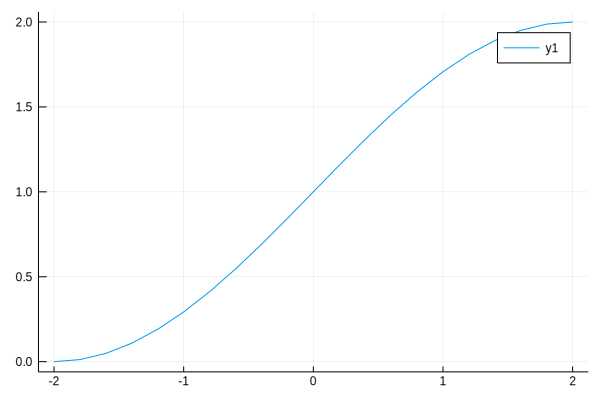

In [11]:
X = -2:0.2:2
Y = [1 + sin((π/4)p) for p ∈ X]
fig = plot(X, Y)

In [12]:
anim = @animate for i in 1:10
    net_err = 0.
    for (x, y) ∈ zip(eachrow(X), eachrow(Y))
        x = convert(Array, x)
        y = convert(Array, y)
        Ŷ = forward(net, x)[end]
        err = net.J.f(Ŷ, y)
        net_err += sum(err)
        backward(net, x, y)
        update(net)
    end
    Ŷ = [forward(net, x)[end] for x ∈ eachrow(X)]
    println("Epoch $i, Error $net_err")
    plot!(fig, X, vcat(Ŷ...), label="Epoch $i")#, Error $net_err)
end

Epoch 1, Error 3.3615331407097253
Epoch 2, Error 5.218705078503079
Epoch 3, Error 5.254714812069711
Epoch 4, Error 5.17952178975711
Epoch 5, Error 5.075834445367916
Epoch 6, Error 4.871777716634619
Epoch 7, Error 4.4566646967385655
Epoch 8, Error 3.7200454756765176
Epoch 9, Error 2.7081135991889695
Epoch 10, Error 1.6958819455061855


Animation("/tmp/tmpQXQBM3", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"])

In [13]:
;rm ./backpropagation.gif

In [14]:
gif(anim, "./backpropagation.gif", fps=1)

┌ Info: Saved animation to 
│   fn = /home/emilio1625/Proyectos/0751-nlp/ml/src/backpropagation.gif
└ @ Plots /home/emilio1625/.julia/packages/Plots/Iuc9S/src/animation.jl:95


Plots.AnimatedGif("/home/emilio1625/Proyectos/0751-nlp/ml/src/backpropagation.gif")

In [15]:
# Comprobacion usando el gradiente numerico
for (x, y) ∈ zip(eachrow(X), eachrow(Y))
    Ŷ = forward(net, x)[end]
    ∂J = backward(net, x, y)
    ϵ = 1e-4
    loss1 = net.J.f(Ŷ .+ ϵ, y)
    #println(loss1)
    loss2 = net.J.f(Ŷ .- ϵ, y)
    #println(loss2)
    numgrad = (loss1-loss2)/(2*ϵ)
    println("Num: $numgrad, Calc: $∂J")
end

Num: [0.682337], Calc: [0.682337]
Num: [0.706951], Calc: [0.706951]
Num: [0.712812], Calc: [0.712812]
Num: [0.701024], Calc: [0.701024]
Num: [0.673035], Calc: [0.673035]
Num: [0.630539], Calc: [0.630539]
Num: [0.575381], Calc: [0.575381]
Num: [0.509492], Calc: [0.509492]
Num: [0.434853], Calc: [0.434853]
Num: [0.353503], Calc: [0.353503]
Num: [0.26758], Calc: [0.26758]
Num: [0.179374], Calc: [0.179374]
Num: [0.0913673], Calc: [0.0913673]
Num: [0.00624415], Calc: [0.00624415]
Num: [-0.0731508], Calc: [-0.0731508]
Num: [-0.143896], Calc: [-0.143896]
Num: [-0.20311], Calc: [-0.20311]
Num: [-0.248091], Calc: [-0.248091]
Num: [-0.276444], Calc: [-0.276444]
Num: [-0.286207], Calc: [-0.286207]
Num: [-0.275937], Calc: [-0.275937]
